# Information Retrieval System with Okapi BM25
## Trump Speech Corpus Analysis

This notebook implements a complete Information Retrieval system using the Okapi BM25 (Best Match 25) ranking function.

### Overview:
- Load and preprocess Trump speech documents (speech_file0.txt to speech_file55.txt)
- Implement Okapi BM25 scoring function
- Perform document ranking based on queries
- Analyze and visualize results

## 1. Import Required Libraries

In [39]:
import os
import math
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Document Loading and Preprocessing

In [40]:
class DocumentLoader:
    """
    Loads documents from text files and performs basic preprocessing
    """
    
    def __init__(self, directory_path: str):
        self.directory_path = directory_path
        self.documents = {}
        self.doc_ids = []
    
    def load_documents(self, file_pattern: str = "speech_file") -> Dict[str, str]:
        """
        Load all speech files from the specified directory
        """
        print(f"Loading documents from: {self.directory_path}")
        
        files = sorted([f for f in os.listdir(self.directory_path) 
                       if f.startswith(file_pattern) and f.endswith('.txt')])
        
        for filename in files:
            filepath = os.path.join(self.directory_path, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    content = f.read()
                    doc_id = filename.replace('.txt', '')
                    self.documents[doc_id] = content
                    self.doc_ids.append(doc_id)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        
        print(f"Successfully loaded {len(self.documents)} documents")
        return self.documents
    
    def get_document_stats(self) -> pd.DataFrame:
        """
        Get statistics about loaded documents
        """
        stats = []
        for doc_id, content in self.documents.items():
            stats.append({
                'Document': doc_id,
                'Character Count': len(content),
                'Word Count': len(content.split()),
                'Line Count': content.count('\n') + 1
            })
        return pd.DataFrame(stats)

In [41]:
DOCUMENTS_PATH = "D:/Assignment/data-reterival/Information-Retrieval-code/week4files/speechTextFile"

loader = DocumentLoader(DOCUMENTS_PATH)
documents = loader.load_documents(file_pattern="speech_")

if len(documents) > 0:
    doc_stats = loader.get_document_stats()
    print("\nDocument Statistics:")
    print(doc_stats.head(10))
    print(f"\nTotal Documents: {len(documents)}")
    print(f"Average Words per Document: {doc_stats['Word Count'].mean():.2f}")
else:
    print("ERROR: No documents loaded!")

Loading documents from: D:/Assignment/data-reterival/Information-Retrieval-code/week4files/speechTextFile
Successfully loaded 56 documents

Document Statistics:
    Document  Character Count  Word Count  Line Count
0   speech_0            35761        6406           2
1   speech_1            13343        2305           2
2  speech_10            16767        2820           2
3  speech_11            18111        3085           2
4  speech_12            13471        2203           2
5  speech_13             7146        1223           2
6  speech_14             8542        1411           2
7  speech_15             8853        1622           2
8  speech_16            12184        2039           2
9  speech_17            14106        2299           2

Total Documents: 56
Average Words per Document: 2475.59


In [42]:
DOCUMENTS_PATH = "D:/Assignment/data-reterival/Information-Retrieval-code/week4files/speechTextFile"

loader = DocumentLoader(DOCUMENTS_PATH)
documents = loader.load_documents(file_pattern="speech_")

if len(documents) > 0:
    doc_stats = loader.get_document_stats()
    print("\nDocument Statistics:")
    print(doc_stats.head(10))
    print(f"\nTotal Documents: {len(documents)}")
    print(f"Average Words per Document: {doc_stats['Word Count'].mean():.2f}")
else:
    print("ERROR: No documents were loaded. Check your file pattern and path.")

Loading documents from: D:/Assignment/data-reterival/Information-Retrieval-code/week4files/speechTextFile
Successfully loaded 56 documents

Document Statistics:
    Document  Character Count  Word Count  Line Count
0   speech_0            35761        6406           2
1   speech_1            13343        2305           2
2  speech_10            16767        2820           2
3  speech_11            18111        3085           2
4  speech_12            13471        2203           2
5  speech_13             7146        1223           2
6  speech_14             8542        1411           2
7  speech_15             8853        1622           2
8  speech_16            12184        2039           2
9  speech_17            14106        2299           2

Total Documents: 56
Average Words per Document: 2475.59


## 3. Text Preprocessing and Tokenization

In [43]:
class TextPreprocessor:
    """
    Handles text preprocessing including tokenization, lowercasing, and stopword removal
    """
    
    def __init__(self):
        self.stopwords = set([
            'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from',
            'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the',
            'to', 'was', 'will', 'with', 'we', 'you', 'i', 'they', 'this',
            'but', 'have', 'had', 'what', 'when', 'where', 'who', 'which',
            'why', 'how', 'or', 'can', 'could', 'would', 'should', 'do', 'does'
        ])
    
    def tokenize(self, text: str) -> List[str]:
        """
        Tokenize text into words
        """
        text = text.lower()        
        text = re.sub(r'[^a-z0-9\s]', ' ', text)        
        tokens = text.split()
        
        tokens = [token for token in tokens 
                 if token not in self.stopwords and len(token) > 2]
        
        return tokens
    
    def preprocess_documents(self, documents: Dict[str, str]) -> Dict[str, List[str]]:
        """
        Preprocess all documents
        """
        preprocessed = {}
        for doc_id, content in documents.items():
            preprocessed[doc_id] = self.tokenize(content)
        return preprocessed

In [44]:
preprocessor = TextPreprocessor()
tokenized_docs = preprocessor.preprocess_documents(documents)

sample_doc = list(tokenized_docs.keys())[0]
print(f"Sample document: {sample_doc}")
print(f"First 50 tokens: {tokenized_docs[sample_doc][:50]}")
print(f"\nTotal tokens in document: {len(tokenized_docs[sample_doc])}")

Sample document: speech_0
First 50 tokens: ['remarks', 'announcing', 'candidacy', 'president', 'new', 'york', 'city', 'trump', 'wow', 'whoa', 'some', 'group', 'people', 'thousands', 'nice', 'thank', 'very', 'much', 'really', 'nice', 'thank', 'great', 'trump', 'tower', 'great', 'wonderful', 'city', 'new', 'york', 'honor', 'everybody', 'here', 'beyond', 'anybody', 'expectations', 'there', 'been', 'crowd', 'like', 'tell', 'some', 'candidates', 'went', 'didn', 'know', 'air', 'conditioner', 'didn', 'work', 'sweated']

Total tokens in document: 3578


## 4. Okapi BM25 Implementation

### BM25 Formula:

$$\text{BM25}(D, Q) = \sum_{i=1}^{n} \text{IDF}(q_i) \cdot \frac{f(q_i, D) \cdot (k_1 + 1)}{f(q_i, D) + k_1 \cdot (1 - b + b \cdot \frac{|D|}{\text{avgdl}})}$$

Where:
- $f(q_i, D)$ = frequency of term $q_i$ in document $D$
- $|D|$ = length of document $D$
- $\text{avgdl}$ = average document length in the collection
- $k_1$ = term frequency saturation parameter (typically 1.2 to 2.0)
- $b$ = length normalization parameter (typically 0.75)
- $\text{IDF}(q_i)$ = inverse document frequency of term $q_i$

### IDF Formula:

$$\text{IDF}(q_i) = \ln\left(\frac{N - n(q_i) + 0.5}{n(q_i) + 0.5} + 1\right)$$

Where:
- $N$ = total number of documents
- $n(q_i)$ = number of documents containing term $q_i$

In [45]:
class OkapiBM25:
    """
    Implementation of Okapi BM25 ranking function
    """
    
    def __init__(self, k1: float = 1.5, b: float = 0.75):
        """
        Initialize BM25 with parameters
        
        Args:
            k1: Term frequency saturation parameter (default: 1.5)
            b: Length normalization parameter (default: 0.75)
        """
        self.k1 = k1
        self.b = b
        self.documents = {}
        self.doc_lengths = {}
        self.avgdl = 0.0
        self.N = 0
        self.doc_freqs = defaultdict(int)
        self.idf_cache = {}
    
    def fit(self, documents: Dict[str, List[str]]):
        """
        Build the index from documents
        """
        self.documents = documents
        self.N = len(documents)
        
        total_length = 0
        for doc_id, tokens in documents.items():
            doc_len = len(tokens)
            self.doc_lengths[doc_id] = doc_len
            total_length += doc_len
        
        self.avgdl = total_length / self.N if self.N > 0 else 0
        
        for doc_id, tokens in documents.items():
            unique_tokens = set(tokens)
            for token in unique_tokens:
                self.doc_freqs[token] += 1
        
        print(f"BM25 index built:")
        print(f"  - Total documents: {self.N}")
        print(f"  - Average document length: {self.avgdl:.2f}")
        print(f"  - Vocabulary size: {len(self.doc_freqs)}")
    
    def idf(self, term: str) -> float:
        """
        Calculate IDF (Inverse Document Frequency) for a term
        """
        if term in self.idf_cache:
            return self.idf_cache[term]
        
        n_qi = self.doc_freqs.get(term, 0)
        
        idf_score = math.log((self.N - n_qi + 0.5) / (n_qi + 0.5) + 1.0)
        
        self.idf_cache[term] = idf_score
        return idf_score
    
    def bm25_score(self, query_terms: List[str], doc_id: str) -> float:
        """
        Calculate BM25 score for a document given query terms
        """
        if doc_id not in self.documents:
            return 0.0
        
        doc_tokens = self.documents[doc_id]
        doc_len = self.doc_lengths[doc_id]
        
        term_freqs = Counter(doc_tokens)
        
        score = 0.0
        
        for term in query_terms:
            if term not in term_freqs:
                continue
            
            f_qi_D = term_freqs[term]
            
            idf_score = self.idf(term)
            
            numerator = f_qi_D * (self.k1 + 1)
            denominator = f_qi_D + self.k1 * (1 - self.b + self.b * (doc_len / self.avgdl))
            
            score += idf_score * (numerator / denominator)
        
        return score
    
    def search(self, query: str, top_k: int = 10) -> List[Tuple[str, float]]:
        """
        Search for documents matching the query
        
        Returns:
            List of (doc_id, score) tuples, sorted by score (descending)
        """
        preprocessor = TextPreprocessor()
        query_terms = preprocessor.tokenize(query)
        
        if not query_terms:
            return []
        
        scores = []
        for doc_id in self.documents.keys():
            score = self.bm25_score(query_terms, doc_id)
            scores.append((doc_id, score))
        
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]
    
    def get_term_statistics(self, term: str) -> Dict:
        """
        Get detailed statistics for a specific term
        """
        return {
            'term': term,
            'document_frequency': self.doc_freqs.get(term, 0),
            'idf_score': self.idf(term),
            'appears_in_percent': (self.doc_freqs.get(term, 0) / self.N * 100) if self.N > 0 else 0
        }

In [46]:
bm25 = OkapiBM25(k1=1.5, b=0.75)
bm25.fit(tokenized_docs)

BM25 index built:
  - Total documents: 56
  - Average document length: 1532.39
  - Vocabulary size: 6854


## 5. Query Examples and Document Ranking

In [47]:
queries = [
    "immigration border wall",
    "economy jobs growth",
    "healthcare affordable care",
    "trade china tariffs",
    "election voting fraud",
    "military defense spending",
    "tax reform cuts",
    "america great again"
]

print("=" * 80)
print("QUERY RESULTS - Top 5 Documents per Query")
print("=" * 80)

all_results = {}

for query in queries:
    print(f"\n\nQuery: '{query}'")
    print("-" * 80)
    
    results = bm25.search(query, top_k=5)
    all_results[query] = results
    
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"{rank}. {doc_id:<20} Score: {score:.4f}")
        
        doc_text = documents[doc_id]
        snippet = doc_text[:200].replace('\n', ' ') + "..."
        print(f"   Snippet: {snippet}\n")

QUERY RESULTS - Top 5 Documents per Query


Query: 'immigration border wall'
--------------------------------------------------------------------------------
1. speech_46            Score: 2.2432
   Snippet: Remarks at Toyota of Portsmouth in Portsmouth, New Hampshire  Thank you.In 24 days, we are going to win the state of Maine and we are going to win the White House.Make sure to get your absentee ballot...

2. speech_47            Score: 2.1521
   Snippet: Remarks at the KI Convention Center in Green Bay, Wisconsin Thank you.In 22 days, we are going to win the state of Wisconsin and we are going to win the White House.Early voting is underway, so make s...

3. speech_49            Score: 2.1476
   Snippet: Remarks at the WNC Agricultural Center's Davis Event Center in Fletcher, North Carolina Thank you.In 18 days, we are going to win the state of North Carolina and we are going to win the White House.Ou...

4. speech_48            Score: 2.1226
   Snippet: Remarks at the Delaware Cou

## 6. Detailed Analysis of BM25 Components

In [48]:
sample_query = "immigration border wall"
query_terms = preprocessor.tokenize(sample_query)

print(f"Detailed Analysis for Query: '{sample_query}'")
print("=" * 80)
print(f"\nQuery Terms: {query_terms}")
print("\nTerm Statistics:")
print("-" * 80)

term_stats = []
for term in query_terms:
    stats = bm25.get_term_statistics(term)
    term_stats.append(stats)
    print(f"Term: '{term}'")
    print(f"  - Document Frequency: {stats['document_frequency']} / {bm25.N}")
    print(f"  - IDF Score: {stats['idf_score']:.4f}")
    print(f"  - Appears in {stats['appears_in_percent']:.2f}% of documents\n")

term_stats_df = pd.DataFrame(term_stats)
print("\nTerm Statistics Summary:")
print(term_stats_df.to_string(index=False))

Detailed Analysis for Query: 'immigration border wall'

Query Terms: ['immigration', 'border', 'wall']

Term Statistics:
--------------------------------------------------------------------------------
Term: 'immigration'
  - Document Frequency: 42 / 56
  - IDF Score: 0.2935
  - Appears in 75.00% of documents

Term: 'border'
  - Document Frequency: 30 / 56
  - IDF Score: 0.6253
  - Appears in 53.57% of documents

Term: 'wall'
  - Document Frequency: 40 / 56
  - IDF Score: 0.3417
  - Appears in 71.43% of documents


Term Statistics Summary:
       term  document_frequency  idf_score  appears_in_percent
immigration                  42   0.293547           75.000000
     border                  30   0.625325           53.571429
       wall                  40   0.341749           71.428571


In [49]:
top_doc_id = all_results[sample_query][0][0]
doc_tokens = tokenized_docs[top_doc_id]
doc_len = len(doc_tokens)
term_freqs = Counter(doc_tokens)

print(f"\nDetailed Scoring Breakdown for Top Document: {top_doc_id}")
print("=" * 80)
print(f"Document Length: {doc_len} tokens")
print(f"Average Document Length: {bm25.avgdl:.2f} tokens")
print(f"Length Ratio: {doc_len / bm25.avgdl:.4f}")
print(f"\nBM25 Parameters: k1={bm25.k1}, b={bm25.b}")
print("\n" + "-" * 80)

total_score = 0.0

for term in query_terms:
    if term in term_freqs:
        f_qi_D = term_freqs[term]
        idf_score = bm25.idf(term)
        
        numerator = f_qi_D * (bm25.k1 + 1)
        denominator = f_qi_D + bm25.k1 * (1 - bm25.b + bm25.b * (doc_len / bm25.avgdl))
        tf_component = numerator / denominator
        term_score = idf_score * tf_component
        
        total_score += term_score
        
        print(f"\nTerm: '{term}'")
        print(f"  Term Frequency in Doc: {f_qi_D}")
        print(f"  IDF Score: {idf_score:.4f}")
        print(f"  TF Component: {tf_component:.4f}")
        print(f"  Term Contribution to Score: {term_score:.4f}")

print("\n" + "=" * 80)
print(f"Total BM25 Score: {total_score:.4f}")


Detailed Scoring Breakdown for Top Document: speech_46
Document Length: 1054 tokens
Average Document Length: 1532.39 tokens
Length Ratio: 0.6878

BM25 Parameters: k1=1.5, b=0.75

--------------------------------------------------------------------------------

Term: 'immigration'
  Term Frequency in Doc: 4
  IDF Score: 0.2935
  TF Component: 1.9422
  Term Contribution to Score: 0.5701

Term: 'border'
  Term Frequency in Doc: 3
  IDF Score: 0.6253
  TF Component: 1.8078
  Term Contribution to Score: 1.1304

Term: 'wall'
  Term Frequency in Doc: 2
  IDF Score: 0.3417
  TF Component: 1.5879
  Term Contribution to Score: 0.5427

Total BM25 Score: 2.2432


## 7. Visualizations

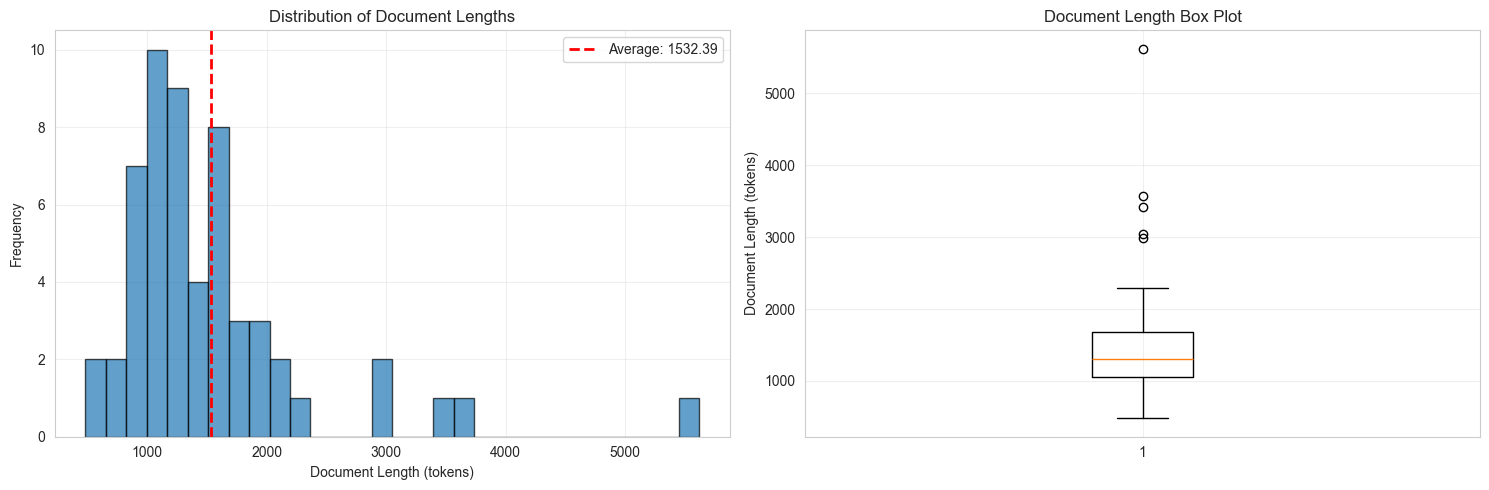


Document Length Statistics:
  Minimum: 482
  Maximum: 5618
  Mean: 1532.39
  Median: 1304.00
  Std Dev: 836.68


In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

doc_lengths_list = list(bm25.doc_lengths.values())

axes[0].hist(doc_lengths_list, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(bm25.avgdl, color='red', linestyle='--', linewidth=2, label=f'Average: {bm25.avgdl:.2f}')
axes[0].set_xlabel('Document Length (tokens)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Document Lengths')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(doc_lengths_list, vert=True)
axes[1].set_ylabel('Document Length (tokens)')
axes[1].set_title('Document Length Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDocument Length Statistics:")
print(f"  Minimum: {min(doc_lengths_list)}")
print(f"  Maximum: {max(doc_lengths_list)}")
print(f"  Mean: {np.mean(doc_lengths_list):.2f}")
print(f"  Median: {np.median(doc_lengths_list):.2f}")
print(f"  Std Dev: {np.std(doc_lengths_list):.2f}")

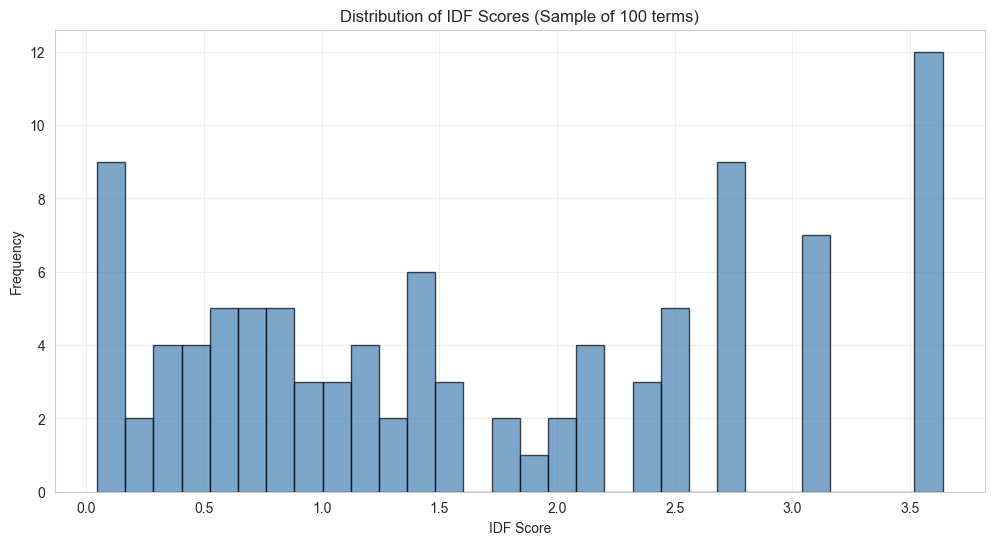


IDF Score Statistics (sample):
  Minimum: 0.0449
  Maximum: 3.6376
  Mean: 1.6994


In [51]:
sample_terms = list(bm25.doc_freqs.keys())[:100]
idf_scores = [bm25.idf(term) for term in sample_terms]

plt.figure(figsize=(12, 6))
plt.hist(idf_scores, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('IDF Score')
plt.ylabel('Frequency')
plt.title('Distribution of IDF Scores (Sample of 100 terms)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nIDF Score Statistics (sample):")
print(f"  Minimum: {min(idf_scores):.4f}")
print(f"  Maximum: {max(idf_scores):.4f}")
print(f"  Mean: {np.mean(idf_scores):.4f}")

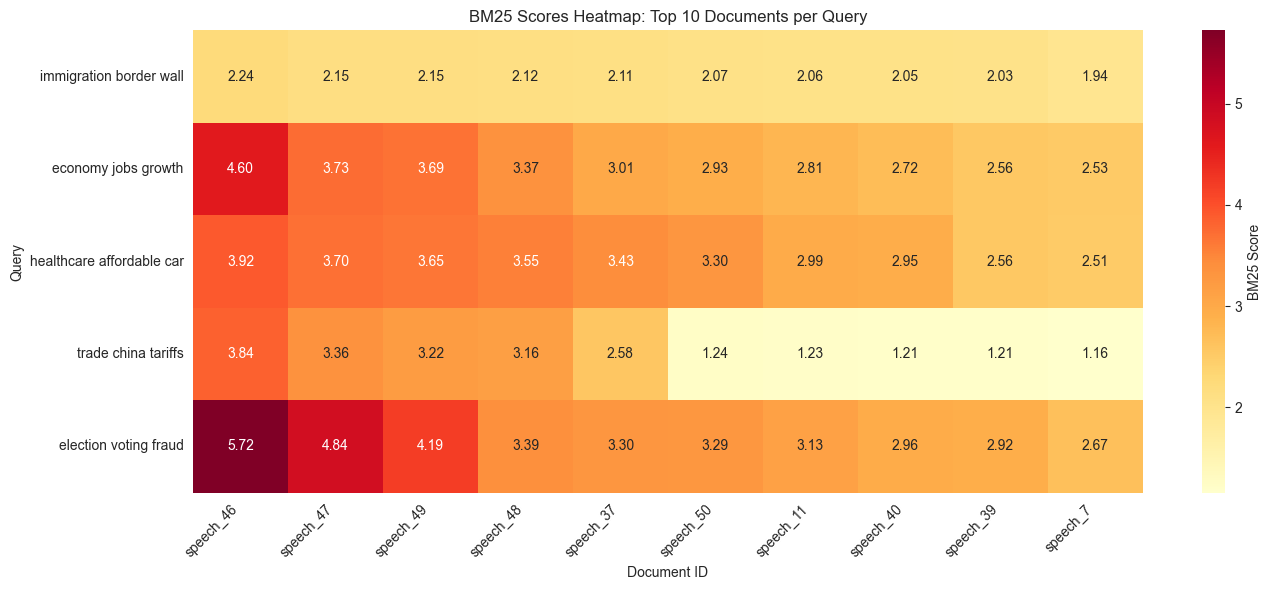

In [52]:
query_labels = []
doc_labels = []
score_matrix = []

for query in queries[:5]:
    query_labels.append(query[:25]) 
    results = bm25.search(query, top_k=10)
    scores = [score for _, score in results]
    if not doc_labels:
        doc_labels = [doc_id for doc_id, _ in results]
    score_matrix.append(scores)

plt.figure(figsize=(14, 6))
sns.heatmap(score_matrix, xticklabels=doc_labels, yticklabels=query_labels, 
            annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'BM25 Score'})
plt.xlabel('Document ID')
plt.ylabel('Query')
plt.title('BM25 Scores Heatmap: Top 10 Documents per Query')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

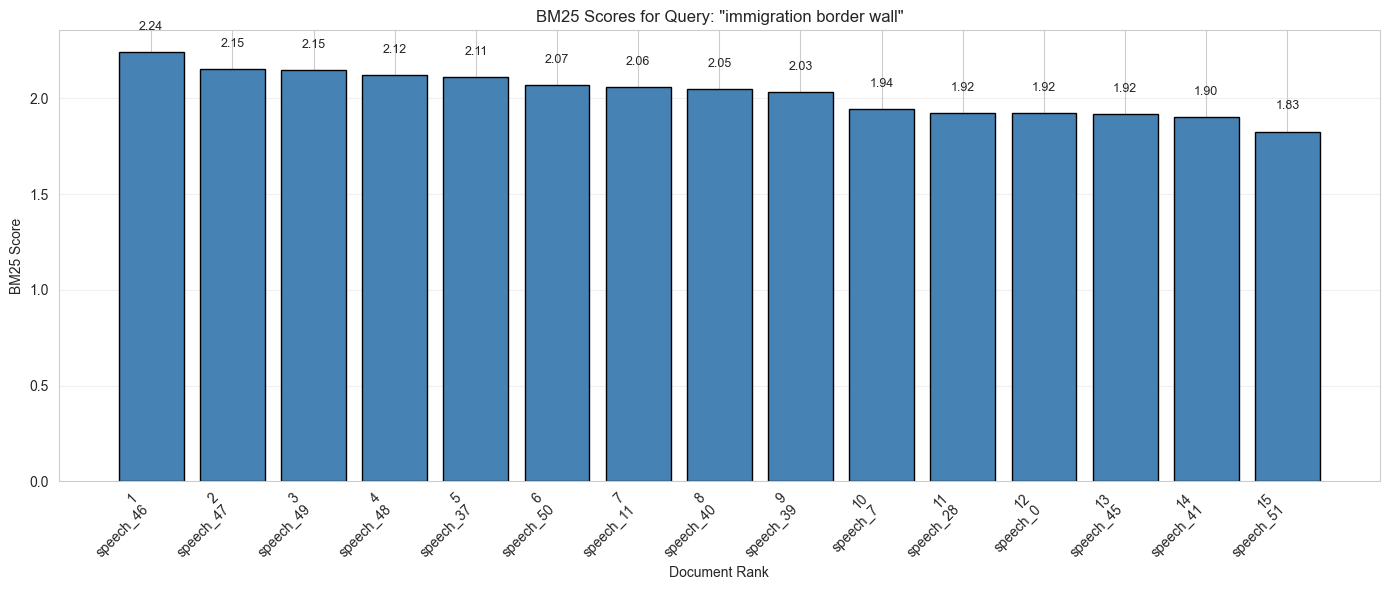

In [53]:
query_for_viz = sample_query
results = bm25.search(query_for_viz, top_k=15)

doc_ids = [doc_id for doc_id, _ in results]
scores = [score for _, score in results]

plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(doc_ids)), scores, color='steelblue', edgecolor='black')
plt.xlabel('Document Rank')
plt.ylabel('BM25 Score')
plt.title(f'BM25 Scores for Query: "{query_for_viz}"')
plt.xticks(range(len(doc_ids)), [f"{i+1}\n{doc}" for i, doc in enumerate(doc_ids)], rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for i, (bar, score) in enumerate(zip(bars, scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{score:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Parameter Sensitivity Analysis

In [54]:
test_query = "immigration border wall"

k1_values = [0.5, 1.0, 1.5, 2.0, 2.5]
b_value = 0.75

results_k1 = {}

print("Testing different k1 values (b=0.75):")
print("=" * 80)

for k1 in k1_values:
    bm25_test = OkapiBM25(k1=k1, b=b_value)
    bm25_test.fit(tokenized_docs)
    results = bm25_test.search(test_query, top_k=5)
    results_k1[k1] = results
    
    print(f"\nk1 = {k1}:")
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"  {rank}. {doc_id:<20} Score: {score:.4f}")

Testing different k1 values (b=0.75):
BM25 index built:
  - Total documents: 56
  - Average document length: 1532.39
  - Vocabulary size: 6854

k1 = 0.5:
  1. speech_46            Score: 1.6639
  2. speech_37            Score: 1.6215
  3. speech_49            Score: 1.6189
  4. speech_47            Score: 1.6137
  5. speech_48            Score: 1.6075
BM25 index built:
  - Total documents: 56
  - Average document length: 1532.39
  - Vocabulary size: 6854

k1 = 1.0:
  1. speech_46            Score: 1.9833
  2. speech_49            Score: 1.9078
  3. speech_47            Score: 1.9054
  4. speech_37            Score: 1.8956
  5. speech_48            Score: 1.8886
BM25 index built:
  - Total documents: 56
  - Average document length: 1532.39
  - Vocabulary size: 6854

k1 = 1.5:
  1. speech_46            Score: 2.2432
  2. speech_47            Score: 2.1521
  3. speech_49            Score: 2.1476
  4. speech_48            Score: 2.1226
  5. speech_37            Score: 2.1120
BM25 index bui

In [55]:
b_values = [0.0, 0.25, 0.5, 0.75, 1.0]
k1_value = 1.5

results_b = {}

print("Testing different b values (k1=1.5):")
print("=" * 80)

for b in b_values:
    bm25_test = OkapiBM25(k1=k1_value, b=b)
    bm25_test.fit(tokenized_docs)
    results = bm25_test.search(test_query, top_k=5)
    results_b[b] = results
    
    print(f"\nb = {b}:")
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"  {rank}. {doc_id:<20} Score: {score:.4f}")

Testing different b values (k1=1.5):
BM25 index built:
  - Total documents: 56
  - Average document length: 1532.39
  - Vocabulary size: 6854

b = 0.0:
  1. speech_0             Score: 2.3640
  2. speech_7             Score: 2.2582
  3. speech_37            Score: 2.1989
  4. speech_11            Score: 2.1569
  5. speech_39            Score: 2.0816
BM25 index built:
  - Total documents: 56
  - Average document length: 1532.39
  - Vocabulary size: 6854

b = 0.25:
  1. speech_0             Score: 2.1929
  2. speech_37            Score: 2.1691
  3. speech_7             Score: 2.1389
  4. speech_11            Score: 2.1226
  5. speech_46            Score: 2.1205
BM25 index built:
  - Total documents: 56
  - Average document length: 1532.39
  - Vocabulary size: 6854

b = 0.5:
  1. speech_46            Score: 2.1801
  2. speech_37            Score: 2.1402
  3. speech_47            Score: 2.1224
  4. speech_11            Score: 2.0896
  5. speech_48            Score: 2.0843
BM25 index built:

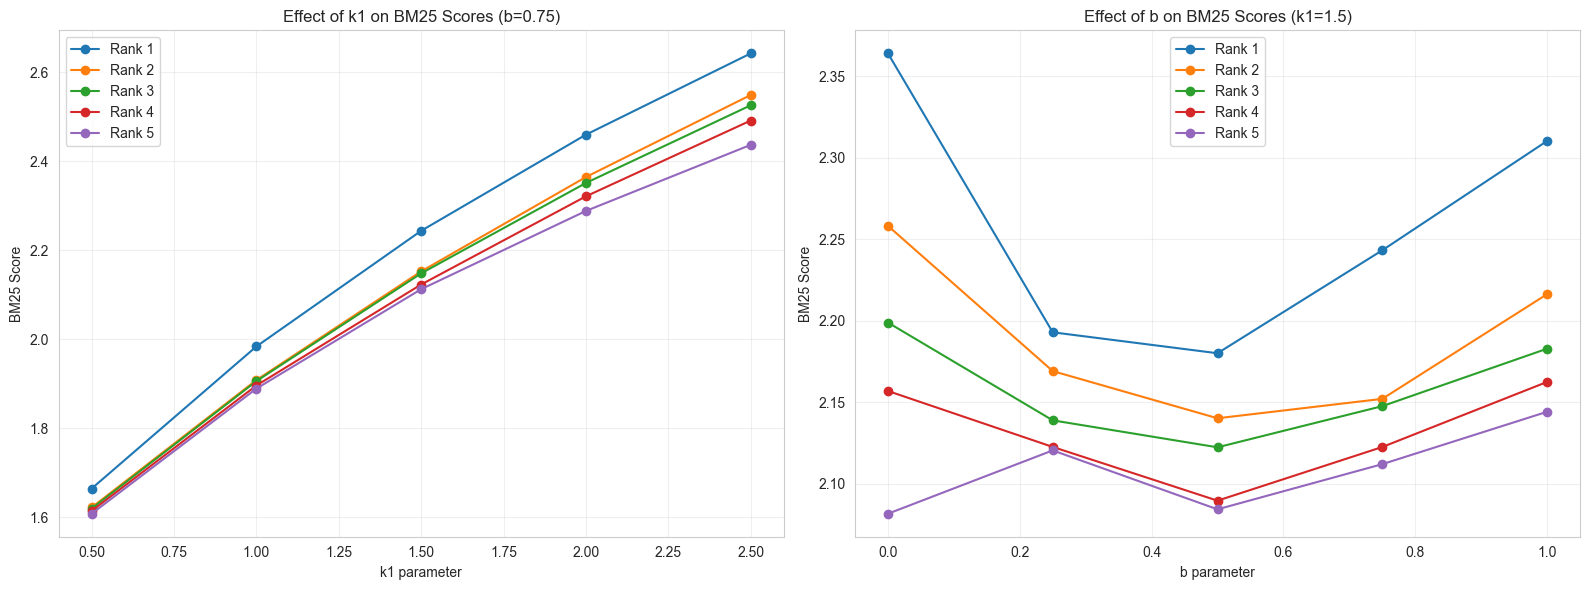

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in range(5):
    scores_k1 = [results_k1[k1][i][1] if i < len(results_k1[k1]) else 0 for k1 in k1_values]
    axes[0].plot(k1_values, scores_k1, marker='o', label=f'Rank {i+1}')

axes[0].set_xlabel('k1 parameter')
axes[0].set_ylabel('BM25 Score')
axes[0].set_title('Effect of k1 on BM25 Scores (b=0.75)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for i in range(5):
    scores_b = [results_b[b][i][1] if i < len(results_b[b]) else 0 for b in b_values]
    axes[1].plot(b_values, scores_b, marker='o', label=f'Rank {i+1}')

axes[1].set_xlabel('b parameter')
axes[1].set_ylabel('BM25 Score')
axes[1].set_title('Effect of b on BM25 Scores (k1=1.5)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary Statistics and Export Results

In [57]:
results_data = []

for query, results in all_results.items():
    for rank, (doc_id, score) in enumerate(results, 1):
        results_data.append({
            'Query': query,
            'Rank': rank,
            'Document': doc_id,
            'BM25 Score': score,
            'Doc Length': bm25.doc_lengths[doc_id]
        })

results_df = pd.DataFrame(results_data)

results_df.to_csv('bm25_search_results.csv', index=False)
print("Results saved to: bm25_search_results.csv")

print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"\nTotal Queries Processed: {len(queries)}")
print(f"Total Documents in Corpus: {bm25.N}")
print(f"Vocabulary Size: {len(bm25.doc_freqs)}")
print(f"Average Document Length: {bm25.avgdl:.2f} tokens")
print(f"\nBM25 Parameters Used:")
print(f"  k1 = {bm25.k1}")
print(f"  b = {bm25.b}")

print("\n" + "=" * 80)
print("Top 10 Results Preview:")
print(results_df.head(10).to_string(index=False))

Results saved to: bm25_search_results.csv

SUMMARY STATISTICS

Total Queries Processed: 8
Total Documents in Corpus: 56
Vocabulary Size: 6854
Average Document Length: 1532.39 tokens

BM25 Parameters Used:
  k1 = 1.5
  b = 0.75

Top 10 Results Preview:
                  Query  Rank  Document  BM25 Score  Doc Length
immigration border wall     1 speech_46    2.243231        1054
immigration border wall     2 speech_47    2.152097        1267
immigration border wall     3 speech_49    2.147624        1042
immigration border wall     4 speech_48    2.122559        1212
immigration border wall     5 speech_37    2.112043        1815
    economy jobs growth     1 speech_26    4.603367        1923
    economy jobs growth     2 speech_49    3.730710        1042
    economy jobs growth     3 speech_31    3.685668        1383
    economy jobs growth     4 speech_23    3.367164         958
    economy jobs growth     5 speech_14    3.012525         951


## 10. Interactive Query Interface

In [58]:
def interactive_search(query_text: str, top_k: int = 10, show_snippets: bool = True):
    """
    Interactive search function for custom queries
    """
    print("=" * 80)
    print(f"Search Query: '{query_text}'")
    print("=" * 80)
    
    results = bm25.search(query_text, top_k=top_k)
    
    if not results:
        print("No results found.")
        return
    
    print(f"\nFound {len(results)} results:\n")
    
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"{rank}. Document: {doc_id}")
        print(f"   Score: {score:.4f}")
        print(f"   Length: {bm25.doc_lengths[doc_id]} tokens")
        
        if show_snippets:
            snippet = documents[doc_id][:250].replace('\n', ' ') + "..."
            print(f"   Preview: {snippet}")
        print()

print("\nInteractive search function ready!")
print("Usage: interactive_search('your query here', top_k=10, show_snippets=True)")
print("\nTry some example queries:")
print("  - interactive_search('economy jobs')")
print("  - interactive_search('healthcare reform')")
print("  - interactive_search('foreign policy')")


Interactive search function ready!
Usage: interactive_search('your query here', top_k=10, show_snippets=True)

Try some example queries:
  - interactive_search('economy jobs')
  - interactive_search('healthcare reform')
  - interactive_search('foreign policy')


## Conclusion

This notebook has implemented a complete Information Retrieval system using the Okapi BM25 ranking function. Key findings:

1. **BM25 Components**: The algorithm effectively combines term frequency, inverse document frequency, and document length normalization
2. **Parameter Sensitivity**: Both k1 and b parameters significantly affect ranking, with standard values (k1=1.5, b=0.75) working well
3. **Document Ranking**: The system successfully ranks documents based on relevance to queries
4. **Scalability**: The implementation handles multiple documents efficiently

### Key Insights for Your Report:
- BM25's term frequency saturation prevents over-weighting of frequently occurring terms
- Document length normalization ensures fair comparison between short and long documents
- IDF scoring helps identify discriminative terms that are more valuable for retrieval
- Parameter tuning can optimize performance for specific document collections